# 7th ESA Advanced Course on Radar Polarimetry 
# Advanced Applications - 15/06/2023
### Irena Hajnsek (ETH Zürich, DLR), Georg Fischer (DLR)

Objective:
- Use polarimetric phase to retrieve information about snow accumulation on the Aletsch glacier in Switzerland

Data:
- Dual-pol (HH, VV) TanDEM-X data over the Aletsch glacier in Switzerland.
- Single Look Complex data during the winter 2016/2017.
- For convenience and computational speed, the data is already geocoded, subsampled and cropped to the area of interest. (Geocoding of SLC data is usually not recommended!)

**Outline of the exercise:**

0. Load libraries, predefined functions and parameters
1. Load data and show amplitudes and phases of a single image
2. Calculate VV-HH phase difference of a single image
3. Times series of backscattered power
4. Times series of VV-HH phase
5. Snow thickness estimation
6. Validation against in situ data


**Import useful libraries**

In [1]:
# import useful libraries, functions, and modules

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from datetime import datetime, timedelta

#%matplotlib widget

**Predefined functions**

In [2]:
def calculate_covariance(im1, im2, looksr, looksa) : 
    
    corr = uniform_filter(np.real(im1*np.conj(im2)), [looksa,looksr]) + 1j* \
                uniform_filter(np.imag(im1*np.conj(im2)), [looksa,looksr])
    
    return corr

def snow_thickness_from_CPD_phase(CPD_phase, theta, wavelength, po=0.2, DoA=0.85):
    # -*- coding: utf-8 -*-
    """
    Calculate snow depth based on VV-HH phase with the snow anisotropy model described in 
    S. Leinss, H. Löwe, M. Proksch, J. Lemmetyinen, A. Wiesmann, and I. Hajnsek, 
    “Anisotropy of seasonal snow measured by polarimetric phase differences in radar time series,” 
    The Cryosphere, vol. 10, no. 4, Art. no. 4, Aug. 2016, doi: 10.5194/tc-10-1771-2016.

    :param CPD_phase: VV-HH phase
    :param theta: incidence angle in radians
    :param wavelength: wavelength of the SAR data
    :param po: assumed snow density, default = 0.2 g/cm³
    :param DoA: assumed Degree of Anisotropy (the axis ratio), default = 0.85
    :return: snow thickness (same units as input wavelength)
    """

    # Parameters
    epsilon_air = 1
    epsilon_ice = 3.15 - 0.0005j
    ivf = po / 0.917  # ice volume fraction

    # Calculate depolarization factors
    if DoA > 1:
        # a_x > a_y = a_z for prolate spheroids
        e = np.sqrt(1 - (1 / DoA) ** 2)
        Nz = ((1 - e ** 2) / (2 * e ** 3)) * (np.log((1 + e) / (1 - e)) - 2 * e)
        Nx = 0.5 * (1 - Nz)
        Ny = Nx
    elif DoA < 1:
        # a_x = a_y > a_z for oblate spheroids
        e = np.sqrt(((1 / DoA) ** 2) - 1)
        Nz = (1 + e ** 2) / (e ** 3) * (e - np.arctan(e))
        Nx = 0.5 * (1 - Nz)
        Ny = Nx

    # Effective permitivities in x y and z direction
    epsilon_x_y = epsilon_air + ivf * epsilon_air * (epsilon_ice - epsilon_air) / (
                  epsilon_air + (1 - ivf) * Nx * (epsilon_ice - epsilon_air))
    epsilon_z = epsilon_air + ivf * epsilon_air * (epsilon_ice - epsilon_air) / (
                epsilon_air + (1 - ivf) * Nz * (epsilon_ice - epsilon_air))

    # Effective permittivities projected to horizontal and vertical polarizations
    epsilon_H = epsilon_x_y
    n_H = np.sqrt(epsilon_H)
    n_V = np.sqrt(np.real((epsilon_H + (1 - (epsilon_H / epsilon_z)) * np.sin(theta) ** 2)))

    # Snow depth calculation
    snow_thickness = (-1) * (CPD_phase * wavelength / (4 * np.pi)) * (1.0 / (
                     np.sqrt(np.real(n_V ** 2 - (np.sin(theta) ** 2))) - (
                     np.sqrt(np.real(n_H ** 2 - (np.sin(theta) ** 2))))))

    return snow_thickness

**Paths and parameters**

In [3]:
# --- input path & images
path = '/home/Data/Hajnsek/'
#path = '/projects/data/applications/TSX_data_Aletsch/'

# --- multilook window size
looksa = 5
looksr = 5

# --- Latitude and Longitude coordinates of the data
lat_limits = (46.39, 46.57)
lon_limits = (7.95, 8.1)

# --- Acquisition dates (to be used for data filenames)
dates = ['20161105', '20161116', '20161208', '20161219', '20161230', '20170110', '20170121', '20170201', '20170212', 
         '20170223', '20170306', '20170317', '20170328', '20170408', '20170419', '20170430', '20170511', '20170522']

# --- 3 selected examples
no_snow = '20161105'
fresh_snow = '20170317'
melting = '20170522'

**Step 1 : Load data and show amplitudes and phases**

- For one image (i.e. with the "no_snow" time step)
- HH and VV amplitudes and phases
- Try a different date during "fresh_snow" or "melting" conditions

*Questions*
- What information is contained in the amplitudes?
- What is the information content of a single-image, single-polarization phase?

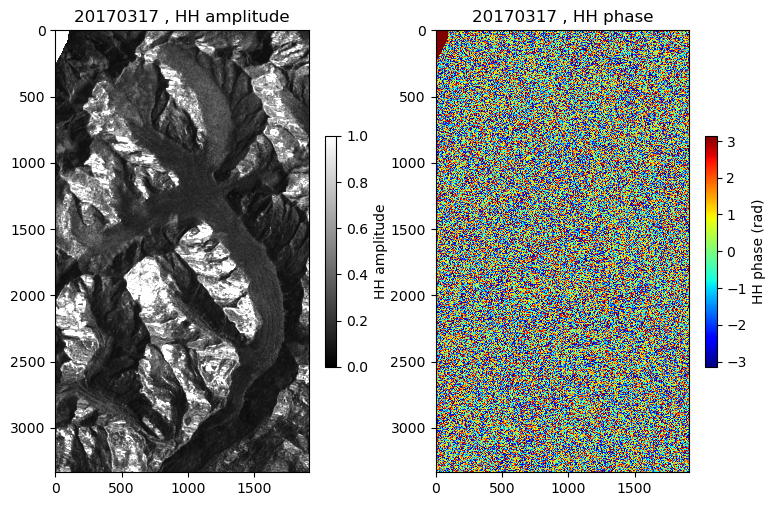

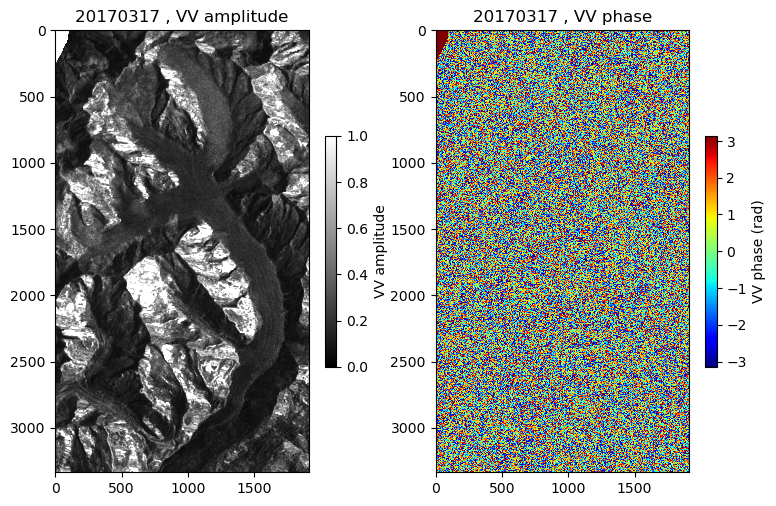

In [4]:
# --- select date   <======= TO BE PLAYED AROUND WITH !
date = fresh_snow

# --- load data for the selected date
im1_hh = np.load(path + 'geo_slc_'+date+'_HH.npy')
im1_vv = np.load(path + 'geo_slc_'+date+'_VV.npy')

# --- amplitude
amp1_hh = np.sqrt(np.abs(calculate_covariance(im1_hh,im1_hh, looksr, looksa)))
amp1_vv = np.sqrt(np.abs(calculate_covariance(im1_vv,im1_vv, looksr, looksa)))

# --- display HH amplitude and (single-look) phase
plt.figure(figsize = (9, 6))
plt.subplot(1, 2, 1)
plt.imshow(amp1_hh, vmin = 0, vmax = 1, cmap = 'gray')
plt.title(date + ' , HH amplitude')
plt.colorbar(label = 'HH amplitude', shrink=0.5)
plt.subplot(1, 2, 2)
plt.imshow(np.angle(im1_vv), vmin = -np.pi, vmax = np.pi, cmap = 'jet', interpolation = 'nearest')
plt.title(date + ' , HH phase')
plt.colorbar(label = 'HH phase (rad)', shrink=0.5)

# --- display VV amplitude and (single-look) phase
plt.figure(figsize = (9, 6))
plt.subplot(1, 2, 1)
plt.imshow(amp1_vv, vmin = 0, vmax = 1, cmap = 'gray')
plt.title(date + ' , VV amplitude')
plt.colorbar(label = 'VV amplitude', shrink=0.5)
plt.subplot(1, 2, 2)
plt.imshow(np.angle(im1_vv), vmin = -np.pi, vmax = np.pi, cmap = 'jet', interpolation = 'nearest')
plt.title(date + ' , VV phase')
plt.colorbar(label = 'VV phase (rad)', shrink=0.5)

# clean up memory
del amp1_hh,amp1_vv

**Step 2a : Calculate VV-HH phase difference and coherence**

- For the example used above
- First directly on the single-look data
- Second with a multilooking window (use predefined calculate_covariance function with looksr, looksa parameters)
- Third calculate polarimetric coherence

*Questions*
- What do we see in this phase difference?
- What is the effect of multilooking? What is changing if you change the number of looks?
- Do we see a difference between melting and frozen conditions? And why?


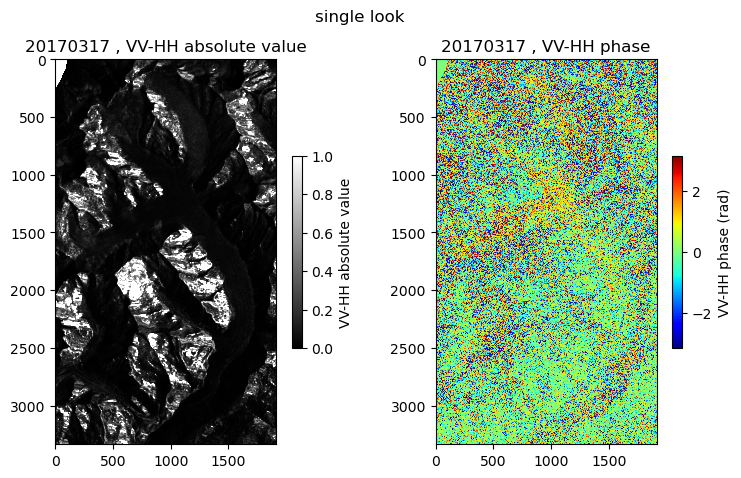

In [5]:
# --- select date   <======= TO BE PLAYED AROUND WITH !
date = fresh_snow

# --- load data for the selected date
im1_hh = np.load(path + 'geo_slc_'+date+'_HH.npy')
im1_vv = np.load(path + 'geo_slc_'+date+'_VV.npy')

# --- save size for later use
size = im1_hh.shape

# --- calculate the VV-HH phase difference (use the im1_vv and im1_hh from above)  <======= TO BE COMPLETED !
vvhh_phase_complex = im1_vv*np.conj(im1_hh)

# --- display VV-HH phase without multilooking
plt.figure(figsize = (9, 5))
plt.suptitle('single look')
plt.subplot(1, 2, 1)
plt.imshow(np.abs(vvhh_phase_complex), vmin = 0, vmax = 1, cmap = 'gray')
plt.title(date + ' , VV-HH absolute value')
plt.colorbar(label = 'VV-HH absolute value', shrink=0.5)
plt.subplot(1, 2, 2)
plt.imshow(np.angle(vvhh_phase_complex), vmin = -np.pi, vmax = np.pi, cmap = 'jet', interpolation = 'nearest')
plt.title(date + ' , VV-HH phase')
plt.colorbar(label = 'VV-HH phase (rad)', shrink=0.5)

# clean up memory
del vvhh_phase_complex

**Step 2b : Calculate VV-HH phase difference and coherence**

... now with multilooking

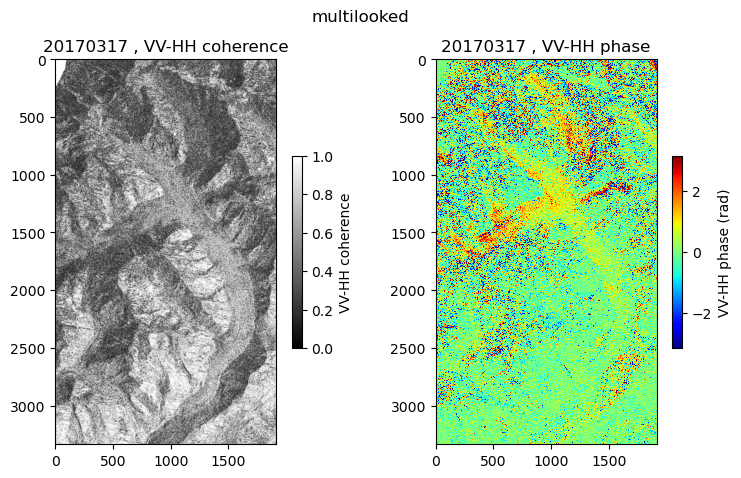

In [6]:
# --- multilook window size   <======= TO BE PLAYED AROUND WITH !
looksa = 5
looksr = 5

# --- calculate the VV-HH phase difference using a multilooking estimation window
vvhh_phase_covariance = calculate_covariance(im1_vv, im1_hh, looksr, looksa)

# --- normalize with VV and HH powers to get the coherence  <======= TO BE COMPLETED !
power_vv = calculate_covariance(im1_vv, im1_vv, looksr, looksa)
power_hh = calculate_covariance(im1_hh, im1_hh, looksr, looksa)
vvhh_phase_coherence = vvhh_phase_covariance/np.sqrt(power_vv * power_hh)

# --- display multilooked VV-HH phase
plt.figure(figsize = (9, 5))
plt.suptitle('multilooked')
plt.subplot(1, 2, 1)
plt.imshow(np.abs(vvhh_phase_coherence), vmin = 0, vmax = 1, cmap = 'gray')
plt.title(date + ' , VV-HH coherence')
plt.colorbar(label = 'VV-HH coherence', shrink=0.5)
plt.subplot(1, 2, 2)
plt.imshow(np.angle(vvhh_phase_coherence), vmin = -np.pi, vmax = np.pi, cmap = 'jet', interpolation = 'nearest')
plt.title(date + ' , VV-HH phase')
plt.colorbar(label = 'VV-HH phase (rad)', shrink=0.5)

# clean up memory
del vvhh_phase_covariance, power_vv, power_hh, vvhh_phase_coherence

**Step 3a : Time series of backscattered power in HH**

- Let's plot the backscattered power of all our images covering the winter 2016/2017

*Questions*
- Can we see a temporal evolution?
- What happened on 2016/12/30 and 2017/04/08?

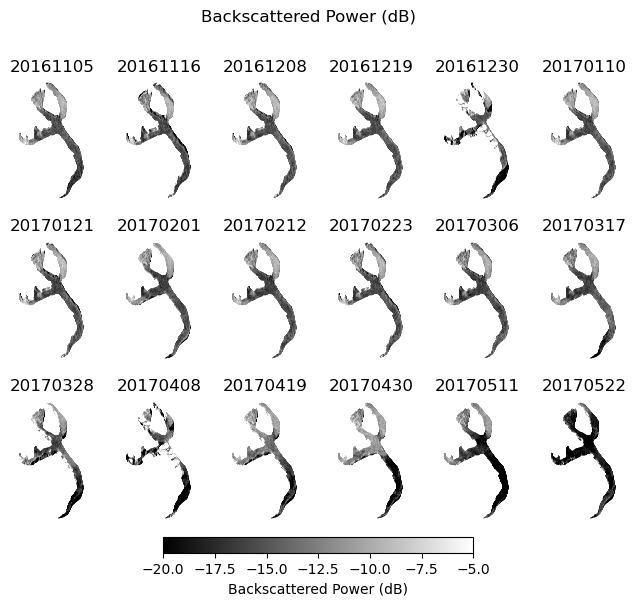

In [7]:
# set up figure
fig = plt.figure(figsize = (8, 7))
plt.suptitle('Backscattered Power (dB)')
nr_dates = len(dates)

# load mask (value 1 on glacier, value 0 around)
mask = np.load(path+'mask.npy')

# output array
power_hh = np.zeros((nr_dates,*size))

for dd, date in enumerate(dates):
    # --- load data for the selected date
    im_hh = np.load(path + 'geo_slc_'+date+'_HH.npy')
        
    # --- Power (beta_nought)
    power_hh[dd,...] = 10*np.log10(np.abs(calculate_covariance(im_hh,im_hh, looksr, looksa)))

    # --- display multilooked backscattered power
    plt.subplot(3, nr_dates//3, dd+1)
    plt.imshow(power_hh[dd,...]*mask, vmin = -20, vmax = -5, cmap = 'gray')
    plt.title(date)
    plt.axis('off')

# add colorbar below
axes = fig.axes        
plt.colorbar(ax=axes, label = 'Backscattered Power (dB)', orientation='horizontal', shrink=0.5, pad=0.01)

**Step 3b : Time series of backscattered power in HH**

- Let's extract the backscattered power at specific locations and make a plot
- Try the following areas: 
    - Near Concordia plateau: [1300:1900,1100:1700]
    - High up in the accumulation zone: [500:700, 1100:1300]
    - Glacier tongue: [2600:2800, 1300:1400]

*Questions*
- Can we see the different timings of snow melt in the different areas?

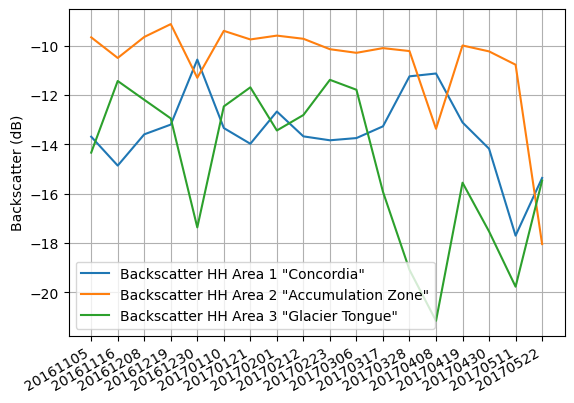

In [8]:
# --- area of interest  <======= Please select other regions !
aoi1 = np.index_exp[:,1300:1900,1100:1700]
aoi2 = np.index_exp[:,500:700, 1100:1300]
aoi3 = np.index_exp[:,2600:2800, 1300:1400]

# --- extract values at the area of interest from the power_hh array we created in the previous step 
power_HH_aoi1 = np.nanmean(power_hh[aoi1], axis=(1,2))
power_HH_aoi2 = np.nanmean(power_hh[aoi2], axis=(1,2))
power_HH_aoi3 = np.nanmean(power_hh[aoi3], axis=(1,2))

# --- plot backscattered power over time
plt.figure()
plt.plot(dates,power_HH_aoi1, label='Backscatter HH Area 1 "Concordia"')
plt.plot(dates,power_HH_aoi2, label='Backscatter HH Area 2 "Accumulation Zone"')
plt.plot(dates,power_HH_aoi3, label='Backscatter HH Area 3 "Glacier Tongue"')
plt.grid()
plt.ylabel('Backscatter (dB)')
plt.gcf().autofmt_xdate()
plt.legend()

**Step 4a : Time series of VV-HH phase**

- Let's plot the VV-HH phase of all our images covering the winter 2016/2017

*Questions*
- Can we see a temporal evolution?

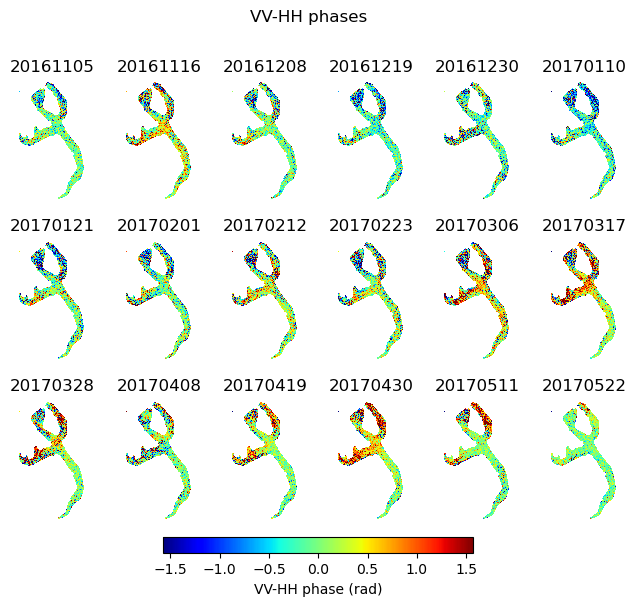

In [9]:
# clean up memory
if 'power_hh' in globals(): del power_hh

# set up figure
fig = plt.figure(figsize = (8, 7))
plt.suptitle('VV-HH phases')
nr_dates = len(dates)

# output array of all CPD phases
CPD_phases = np.ma.zeros((nr_dates,*size))

for dd, date in enumerate(dates):
    # --- load data for the selected date
    im_hh = np.load(path + 'geo_slc_'+date+'_HH.npy')
    im_vv = np.load(path + 'geo_slc_'+date+'_VV.npy')
    
    # --- calculate multilooked VV-HH phase
    vvhh_phase_covariance = calculate_covariance(im_vv, im_hh, looksr, looksa)
    
    # --- extract phase values
    CPD_phase = np.angle(vvhh_phase_covariance)
    
    # --- apply mask
    CPD_phases[dd,...] = np.ma.masked_where(mask == 0,CPD_phase)

    # --- display multilooked VV-HH phase
    plt.subplot(3, nr_dates//3, dd+1)
    plt.imshow(CPD_phases[dd,...], vmin = -np.pi/2, vmax = np.pi/2, cmap = 'jet', interpolation = 'nearest')
    plt.title(date)
    plt.axis('off')

# add colorbar below
axes = fig.axes        
plt.colorbar(ax=axes, label = 'VV-HH phase (rad)', orientation='horizontal', shrink=0.5, pad=0.01)

# clean up memory
del CPD_phase

**Step 4b : Time series of VV-HH phase**

- Let's extract the VV-HH phase at specific locations and make a plot
- Try the following areas: 
    - Below Concordia plateau near in situ station: [1600:1900,1300:1500]
    - High up in the accumulation zone: [500:700, 1100:1300]
    - Glacier tongue: [2600:2800, 1300:1400]

*Question:*
- Why is the ppolarimetric phase different between the selected regions?

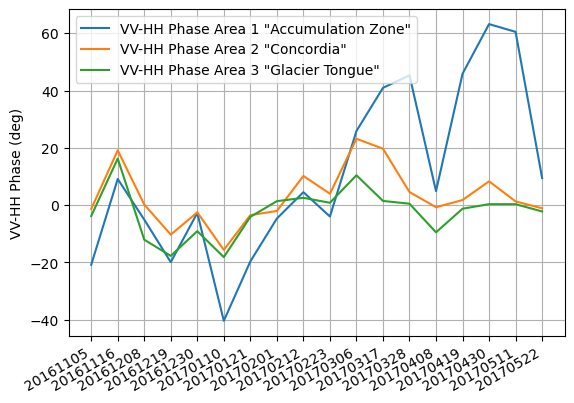

In [10]:
# --- area of interest  
aoi1 = np.index_exp[:,500:700, 1100:1300] # Accumulation Zone
aoi2 = np.index_exp[:,1600:1900,1300:1500] # Concordia
aoi3 = np.index_exp[:,2600:2800, 1300:1400] # Glacier Tongue

# --- extract values at the area of interest from the power_hh array we created in the previous step  <======= TO BE COMPLETED !
CPD_phase_HH_aoi1 = np.mean(CPD_phases[aoi1], axis=(1,2))
CPD_phase_HH_aoi2 = np.mean(CPD_phases[aoi2], axis=(1,2))
CPD_phase_HH_aoi3 = np.mean(CPD_phases[aoi3], axis=(1,2))

# --- plot backscattered power over time
plt.figure()
plt.plot(dates,np.rad2deg(CPD_phase_HH_aoi1), label='VV-HH Phase Area 1 "Accumulation Zone"')
plt.plot(dates,np.rad2deg(CPD_phase_HH_aoi2), label='VV-HH Phase Area 2 "Concordia"')
plt.plot(dates,np.rad2deg(CPD_phase_HH_aoi3), label='VV-HH Phase Area 3 "Glacier Tongue"')
plt.grid()
plt.ylabel('VV-HH Phase (deg)')
plt.gcf().autofmt_xdate()
plt.legend()

**Step 5 : Use snow anisotropy model to invert snow thickness from VV-HH phase**
- The snow anisotropy model is provided as a predefined function
- Time series of snow thickness estimates

*Questions*
- In addition to the temporal evolution, what are the spatial patterns?

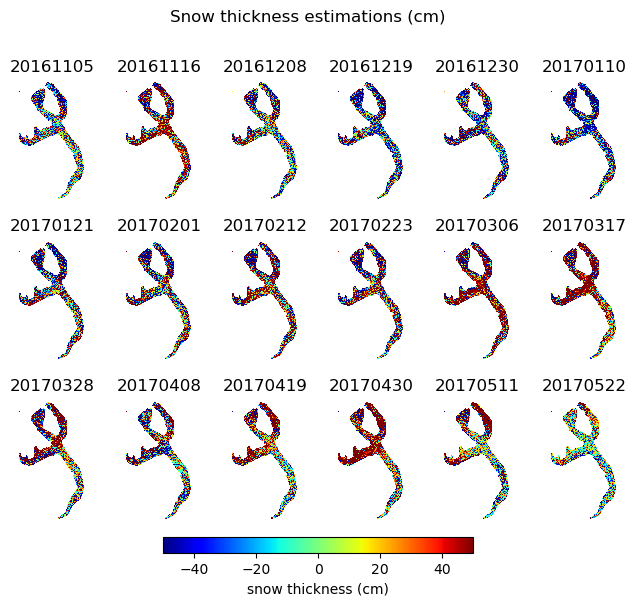

In [11]:
# --- model input parameters 
wavelength = 3.107 # wavelength of TanDEM-X in (cm) # 3.10665814346378255 
po = 0.2           # snow density in (g/cm³) - e.g. 0.1 fresh snow, 0.3 older snow
DoA = 0.85         # snow degree of anisotropy - e.g 1 is a sphere / >1 vertical prolate and <1 horizontal oblate

fig = plt.figure(figsize = (8, 7))
plt.suptitle('Snow thickness estimations (cm)')
nr_dates = len(dates)

# output array of all snow thickness estimates
snow_thickness = np.ma.zeros((nr_dates,*im_hh.shape))

# --- Calculate VV-HH phase for all time steps
for dd, date in enumerate(dates):
        
    # --- get phase value of our CPD_phases array from the previous step
    CPD_phase = CPD_phases[dd,...]
    
     # --- load incidence angle for the selected date
    theta = np.load(path + 'geo_thetainc_'+date+'.npy')
    
    # --- Snow thickness estimate from VV-HH phase
    snow_thickness[dd,...] = snow_thickness_from_CPD_phase(CPD_phase, theta, wavelength, po=po, DoA=DoA)
    
    # --- Plot snow thickness maps
    plt.subplot(3, nr_dates//3, dd+1)
    plt.imshow(snow_thickness[dd,...], vmin = -50, vmax = 50, cmap = 'jet', interpolation = 'nearest')
    plt.title(date)
    plt.axis('off')

# add colorbar below
axes = fig.axes    
plt.colorbar(ax=axes, label = 'snow thickness (cm)', orientation = 'horizontal', shrink=0.5, pad=0.01)

**Step 6a : Validate estimated fresh snow thickness against in situ data**
- Extract snow thickness values for the area of interest (close to the in situ station)
- Make a plot of snow thickness over time

*Questions and adaptations*
- The snow thickness estimated from the VV-HH phase at each date corresponds only to the fresh snow accumulation!
- How can we derive an accumulated total snow height?
- How can we consider (or avoid) decreasing phase values from snow aging (compaction, metamorphism) in an easy way?

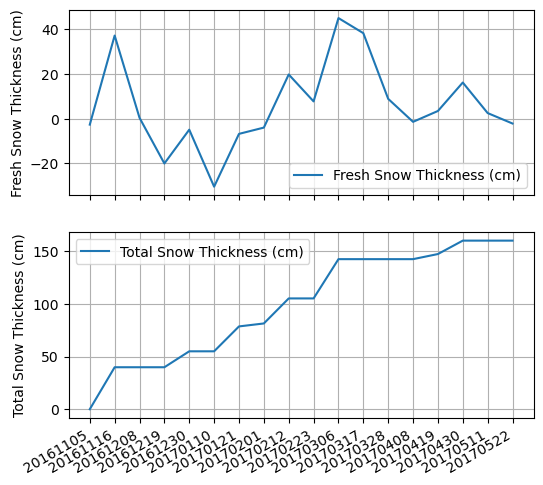

In [12]:
# --- area of interest (close to the in situ station and at similar elevations - below Concordia place)
aoi = np.index_exp[:,1600:1900,1300:1500]

# --- extract average snow thickness of area of interest
snow_thickness_aoi = np.nanmean(snow_thickness[aoi], axis=(1,2))
 
# --- plot retrieved snow thickness changes over time
plt.figure(figsize = (6,6))
plt.subplot(2, 1, 1)
plt.plot(dates,snow_thickness_aoi, label='Fresh Snow Thickness (cm)')
plt.grid()
plt.ylabel('Fresh Snow Thickness (cm)')
plt.gcf().autofmt_xdate()
plt.legend()

# --- accumulated snow thickness of only positive changes w.r.t the last time step  <======= TO BE COMPLETED !
snow_thickness_change = snow_thickness_aoi - np.roll(snow_thickness_aoi,1) # difference calculation to the previous date
snow_thickness_change[snow_thickness_change < 0] = 0  # all what is negative please set to zero
snow_thickness_acc = np.cumsum(snow_thickness_change) # accumulate snow change over time

# --- plot accumulated snow thickness over time
plt.subplot(2, 1, 2)
plt.plot(dates,snow_thickness_acc, label='Total Snow Thickness (cm)')
plt.ylabel('Total Snow Thickness (cm)')
plt.grid()
plt.gcf().autofmt_xdate()
plt.legend()

# clean up memory
# del snow_thickness

**Step 6b : Validate estimated fresh snow thickness against in situ data**
- Let's repeat the snow thickness inversion and test different solutions with different model parameters

*Questions and adaptations*
- How are the results changing with Degree of Anisotropy? And why?

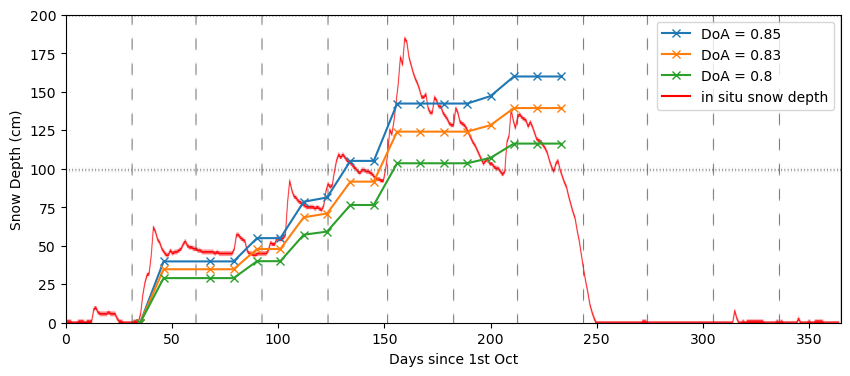

In [13]:
# --- model input parameters
wavelength = 3.107 # wavelength of TanDEM-X in (cm) # 3.10665814346378255 
po = 0.2           # snow density in (g/cm³)
DoA1 = 0.85        # snow degree of anisotropy
DoA2 = 0.83
DoA3 = 0.8

# --- area of interest (close to the in situ station and at similar elevations)
aoi = np.index_exp[:,1600:1900,1300:1500]

# output array of all snow thickness estimates
snow_thickness_aoi1 = np.zeros(nr_dates)
snow_thickness_aoi2 = np.zeros(nr_dates)
snow_thickness_aoi3 = np.zeros(nr_dates)

# --- Calculate VV-HH phase for all time steps
for dd, date in enumerate(dates):
        
    # --- get phase value of our CPD_phases array from the previous step
    CPD_phase = CPD_phases[dd,aoi[1],aoi[2]]
    
     # --- load incidence angle for the selected date
    theta = np.load(path + 'geo_thetainc_'+date+'.npy')[aoi[1:3]]
    
    # --- Snow thickness estimate from VV-HH phase
    snow_thickness_subset1 = snow_thickness_from_CPD_phase(CPD_phase, theta, wavelength, po=po, DoA=DoA1)
    snow_thickness_subset2 = snow_thickness_from_CPD_phase(CPD_phase, theta, wavelength, po=po, DoA=DoA2)
    snow_thickness_subset3 = snow_thickness_from_CPD_phase(CPD_phase, theta, wavelength, po=po, DoA=DoA3)

    # --- extract average snow thickness of area of interest
    snow_thickness_aoi1[dd] = np.nanmean(snow_thickness_subset1)
    snow_thickness_aoi2[dd] = np.nanmean(snow_thickness_subset2)
    snow_thickness_aoi3[dd] = np.nanmean(snow_thickness_subset3)


# --- accumulated snow thickness of only positive changes w.r.t the last time step  <======= TO BE COMPLETED !
snow_thickness_change1 = snow_thickness_aoi1 - np.roll(snow_thickness_aoi1,1)
snow_thickness_change1[snow_thickness_change1 < 0] = 0
snow_thickness_acc1 = np.cumsum(snow_thickness_change1)

snow_thickness_change2 = snow_thickness_aoi2 - np.roll(snow_thickness_aoi2,1)
snow_thickness_change2[snow_thickness_change2 < 0] = 0
snow_thickness_acc2 = np.cumsum(snow_thickness_change2)

snow_thickness_change3 = snow_thickness_aoi3 - np.roll(snow_thickness_aoi3,1)
snow_thickness_change3[snow_thickness_change3 < 0] = 0
snow_thickness_acc3 = np.cumsum(snow_thickness_change3)
    
# --- plot against in situ snow depth data
in_situ = plt.imread(path+'SLF_snow_height_20162017.png')
plt.figure(figsize=(10,4))
plt.imshow(in_situ, extent=(0,365,0,200),aspect='auto')
plt.ylabel('Snow Depth (cm)')
plt.xlabel('Days since 1st Oct')
# modifying "dates" to fit the SLF snow height graphic which covers 1st Oct - 30th Sep
dates_dummy = [datetime.strptime(d,'%Y%m%d').date() for d in dates]
date_indices = [(d - datetime(2016,10,1).date()).days for d in dates_dummy]
# plot accumulated snow thickness
plt.plot(date_indices, snow_thickness_acc1, marker='x', label=f'DoA = {DoA1}')
plt.plot(date_indices, snow_thickness_acc2, marker='x', label=f'DoA = {DoA2}')
plt.plot(date_indices, snow_thickness_acc3, marker='x', label=f'DoA = {DoA3}')
plt.plot(0,0,color='red',label='in situ snow depth')
plt.legend()